# 数据预处理

现实的数据往往是充满噪声的，而没有高质量的数据，就没有高质量的数据挖掘结果。所以，我们需要对数据进行预处理，以提高数据的质量。

数据的质量涉及许多因素，包括：
- 准确性
- 完整性
- 一致性
- 时效性
- 可信性
- 可解释性

数据预处理的主要步骤为：
- 数据清理：通过填写缺失值、光滑噪声数据、识别或删除离群点。并解决不一致性来“清理”数据
- 数据集成：将多个数据源、数据库集成在一个
- 数据规约：将得到的数据进行简化，去除冗余数据
- 数据变换：讲数据进行规范化、数据离散化和数据分层，可以使得数据挖掘在多个抽象层次上进行。

## 1.数据清洗

现实中的数据一般是不完整的、有噪声的和不一致的。**数据清洗**试图填充缺失值、光滑噪声并识别离群点和纠正数据中的不一致。

### 1.1 缺失值
有时候我们获取的数据存在缺失值，这个往往用NaN来表示。

In [1]:
import numpy as np
import pandas as pd

raw_data = {'first_name': ['Jason', np.nan, 'Tina', 'Jake', 'Amy'], 
        'last_name': ['Miller', np.nan, 'Ali', 'Milner', 'Cooze'], 
        'age': [42, np.nan, 36, 24, 73], 
        'sex': ['m', np.nan, 'f', 'm', 'f'], 
        'preTestScore': [4, np.nan, np.nan, 2, 3],
        'postTestScore': [25, np.nan, np.nan, 62, 70]}
df = pd.DataFrame(raw_data)
df

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Tina,Ali,36.0,f,NaN,NaN
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


#### 忽略缺失值
当缺失值较少的时候，我们可以丢弃缺失的元组，而缺失值较多的时候，我们需要采取别的方法

In [2]:
## 判断缺失值
df.isnull()

,first_name,last_name,age,sex,preTestScore,postTestScore
0,False,False,False,False,False,False
1,True,True,True,True,True,True
2,False,False,False,False,True,True
3,False,False,False,False,False,False
4,False,False,False,False,False,False


In [3]:
## 删除缺失值所在的元组（行）
df.dropna(axis=0)

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


#### 人工填写缺失值
该方法对少数缺失值有效，但费时，且当数据非常大时难以实现

In [4]:
## 将序号 1 的年龄填写为30
df_manual = df.copy()
df_manual.loc[1,'age'] = 30
df_manual

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,NaN,NaN,30.0,NaN,NaN,NaN
2,Tina,Ali,36.0,f,NaN,NaN
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


#### 使用一个全局常量填充缺失值

In [5]:
## 用999填充缺失值
df.fillna(value=999)

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,999,999,999.0,999,999.0,999.0
2,Tina,Ali,36.0,f,999.0,999.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


#### 使用属性中心度填充缺失值

In [6]:
## 给定元组均值
df.fillna(value=df.mean())

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.00,m,4.0,25.000000
1,NaN,NaN,43.75,NaN,3.0,52.333333
2,Tina,Ali,36.00,f,3.0,52.333333
3,Jake,Milner,24.00,m,2.0,62.000000
4,Amy,Cooze,73.00,f,3.0,70.000000


#### 使用最可能的值填充缺失值
可使用是回归、贝叶斯等方法确定最可能的值。也可以使用插值法填充。

In [7]:
## 使用上一个值替代
df.fillna(method='ffill')

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.0,25.0
1,Jason,Miller,42.0,m,4.0,25.0
2,Tina,Ali,36.0,f,4.0,25.0
3,Jake,Milner,24.0,m,2.0,62.0
4,Amy,Cooze,73.0,f,3.0,70.0


In [8]:
##使用线性插值法填充
df.interpolate()

,first_name,last_name,age,sex,preTestScore,postTestScore
0,Jason,Miller,42.0,m,4.000000,25.000000
1,NaN,NaN,39.0,NaN,3.333333,37.333333
2,Tina,Ali,36.0,f,2.666667,49.666667
3,Jake,Milner,24.0,m,2.000000,62.000000
4,Amy,Cooze,73.0,f,3.000000,70.000000


### 1.2 噪声数据
噪声（noise）是被测量的变量的随机误差或方差。

#### 分箱（binning）
分箱通过查考数据的“临近”即周围值来光滑有序数据值。由于分箱方法考察邻近值，因此它进行的是局部光滑。

将数据分为$n$个等频的箱中，可以用**箱均值**、**箱中位数**或**箱边界**光滑数据。

In [9]:
data_price = np.array([15,4,8,21,28,21,24,25,34])
data_price

array([15,  4,  8, 21, 28, 21, 24, 25, 34])

In [10]:
## 对数据进行排序
data_price.sort()
data_price

array([ 4,  8, 15, 21, 21, 24, 25, 28, 34])

In [11]:
## 将数据进行分箱， 分3个箱
data_box = data_price.reshape([3,-1])
data_box

array([[ 4,  8, 15],
       [21, 21, 24],
       [25, 28, 34]])

In [12]:
## 用箱均值光滑
np.repeat(data_box.mean(axis=1), 3)

array([ 9.,  9.,  9., 22., 22., 22., 29., 29., 29.])

In [13]:
## 用箱中位数光滑
np.repeat(np.median(data_box, axis=1), 3)

array([ 8.,  8.,  8., 21., 21., 21., 28., 28., 28.])

In [14]:
from scipy import stats
values = [1.0, 1.0, 2.0, 1.5, 3.0]
stats.binned_statistic([1, 1, 2, 5, 7], values, 'mean', bins=3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


BinnedStatisticResult(statistic=array([1.33333333,        nan, 2.25      ]), bin_edges=array([1., 3., 5., 7.]), binnumber=array([1, 1, 1, 3, 3], dtype=int64))

In [15]:
## 用箱边界光滑
np.repeat(data_box.max(axis=1), 3)

array([15, 15, 15, 24, 24, 24, 34, 34, 34])

## 2. 数据规范化

### 2.1 最大最小规范化(min-max scaled)
假设 $min_A$ 和 $max_{A} $ 分别是属性 $A$ 的最小值和最大值，计算公式如下：

$$ v_{i}^{'}  = \frac{v_i - \min_A}{\max_A - \min_A}(new_{maxA} - new_{minA}) + new_{minA} \tag{1} $$

这样就把 $A$ 的值映射到区间 $[new_{maxA} ,new_{minA}]$ 中的 $v_{i}^{'}$ 中。

In [16]:
## min-max scale
from sklearn import preprocessing
X_train = np.array([[ 1., -1.,  2.],
                   [ 2.,  0.,  0.],
                   [ 0.,  1., -1.]])
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train_minmax

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

### 2.2 Z-score 规范化（零均值规范化）

$$ v_{i}^{'}  = \frac{v_i - \bar{A}}{\sigma_A}   \tag{2} $$

通过z-socre规范化，将数值的均值转换成0， 方差转换成1

In [17]:
X_scaled = preprocessing.scale(X_train)
X_scaled

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [18]:
X_scaled.mean()

4.9343245538895844e-17

In [19]:
X_scaled.var()

1.0

### 2.3小数定标
通过移动属性 $A$的小数点位置来进行规范化:

$$ v_{i}^{'}  = \frac{v_i}{10^j}   \tag{3} $$

其中 $j$ 是使得 $max(\left|v^{'}_i \right|) < 1$ 的最小整数

In [20]:
X_train / 10

array([[ 0.1, -0.1,  0.2],
       [ 0.2,  0. ,  0. ],
       [ 0. ,  0.1, -0.1]])

## 3. 主成分分析
主成分分析（principal components anaylysis）主要是利用降维的思想，在损失很少信息的前提下减少数据的维度，通常将转化生成的综合指标称为主成分。每个主成分都是原始变量的线性组合，且各个主成分之间互不相关。

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['simhei']

### 3.1 评价各省市经济效益

In [22]:
data = pd.read_excel('./data/主成分分析.xlsx', sheet_name='5-2', index_col = 0)
data.head()

,100固定资产原值实现值（%）,100元固定资产原值实现利税（%）,100元资金实现利税（%）,100元工业总产值实现利税（%）,100元销售收入实现利税（%）,每吨标准煤实现工业产值（元）,每千瓦时电力实现工业产值（元）,全员劳动生产率（元/人.年）,100元流动资金实现产值（元）
北京（1）,119.29,30.98,29.92,25.97,15.48,2178.00,3.41,21006.0,296.7
天津（2）,143.98,31.59,30.21,21.94,12.29,2852.00,4.29,20254.0,363.1
河北（3）,94.80,17.20,17.95,18.14,9.37,1167.00,2.03,12607.0,322.2
山西（4）,65.80,11.08,11.06,12.15,16.84,8.82,1.65,10166.0,284.7
内蒙（5）,54.79,9.24,9.54,16.86,6.27,894.00,1.80,7564.0,225.4


In [23]:
### 标准化
X = (data - data.mean()) / data.std()

## 导入主成分库，并先选择所有主成分
from sklearn.decomposition import PCA
pca = PCA(n_components = X.shape[1])
## 训练数据
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
## 展示方差解释力度
pd.DataFrame({'方差': pca.explained_variance_,
              '贡献度':pca.explained_variance_ratio_,
             '累计贡献度':pca.explained_variance_ratio_.cumsum()})

,方差,贡献度,累计贡献度
0,6.149885,0.683321,0.683321
1,1.472892,0.163655,0.846975
2,0.697420,0.077491,0.924466
3,0.317825,0.035314,0.959780
4,0.190044,0.021116,0.980896
5,0.116045,0.012894,0.993790
6,0.029118,0.003235,0.997025
7,0.024324,0.002703,0.999728
8,0.002448,0.000272,1.000000


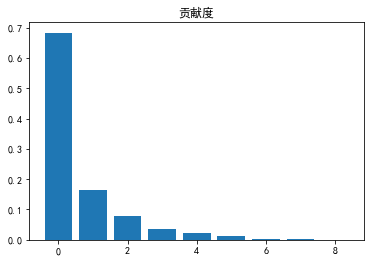

In [25]:
plt.bar(range(9), pca.explained_variance_ratio_)
plt.title('贡献度');

In [26]:
## 选择前两个作为主成分
pca.n_components = 2
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
## 主成分系数：
pd.DataFrame(pca.components_, columns=data.columns)

,100固定资产原值实现值（%）,100元固定资产原值实现利税（%）,100元资金实现利税（%）,100元工业总产值实现利税（%）,100元销售收入实现利税（%）,每吨标准煤实现工业产值（元）,每千瓦时电力实现工业产值（元）,全员劳动生产率（元/人.年）,100元流动资金实现产值（元）
0,0.375559,0.393396,0.375256,0.093534,0.174559,0.372149,0.361616,0.351316,0.362594
1,0.259512,-0.134374,-0.265294,-0.711329,-0.491327,0.164956,0.225403,0.052364,0.126751


In [28]:
## 主成分
y = pd.DataFrame(pca.transform(X), index=data.index)
y

,0,1
北京（1）,2.816238,-2.425742
天津（2）,3.735832,-0.536483
河北（3）,-0.486831,0.097747
山西（4）,-2.021997,-0.384570
内蒙（5）,-2.976298,0.732496
辽宁（6）,-0.418013,-1.267647
吉林（7）,-1.613553,0.809633
黑龙江（8）,-1.041542,-0.692269
上海（9）,7.037722,-1.378583
江苏（10）,3.944277,2.806737


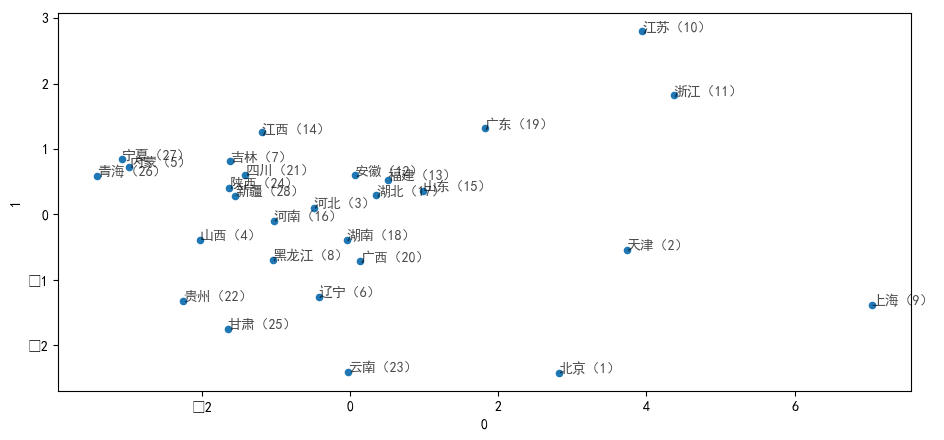

In [29]:
plt.figure(dpi=100, figsize=(11,5))
ax = plt.subplot(111)
y.plot.scatter(0,1, ax=ax, alpha=1)

for i in range(y.shape[0]):
    ax.annotate(data.index[i], (y.iloc[i,0], y.iloc[i,1]),alpha=0.7)

### 3.2 水泥企业经济效益综合评价

In [30]:
data_2 = pd.read_excel('./data/主成分分析.xlsx', sheet_name='5-3', index_col = 0)
data_2.set_index('厂家编号及指标', inplace=True)
## 将 '流动资金周转天数' 和 '万元产值能耗' 取倒数
data_2['流动资金周转天数'] = 1 / data_2['流动资金周转天数']
data_2['万元产值能耗'] = 1 / data_2['万元产值能耗']
data_2.head()

,固定资产利税率,资金利税率,销售收入利税率,资金利润率,固定资产产值率,流动资金周转天数,万元产值能耗,全员劳动生产率
厂家编号及指标,,,,,,,,
琉璃河,16.68,26.75,31.84,18.40,53.25,0.018182,0.034686,1.75
邯郸,19.70,27.56,32.94,19.20,59.82,0.018182,0.030377,2.87
大同,15.20,23.40,32.98,16.24,46.78,0.015385,0.023987,1.53
哈尔滨,7.29,8.97,21.30,4.76,34.39,0.016129,0.025458,1.63
华新,29.45,56.49,40.74,43.68,75.32,0.014493,0.037481,2.14


In [31]:
## 标准化 
X_2 = (data_2 - data_2.mean()) / data_2.std()
X_2.head()

,固定资产利税率,资金利税率,销售收入利税率,资金利润率,固定资产产值率,流动资金周转天数,万元产值能耗,全员劳动生产率
厂家编号及指标,,,,,,,,
琉璃河,-0.376748,-0.357946,-0.113559,-0.366694,-0.038794,1.193347,1.426821,-0.277122
邯郸,0.088158,-0.293876,0.050803,-0.287323,0.356157,1.193347,0.289035,2.253119
大同,-0.604583,-0.622925,0.056779,-0.580995,-0.427733,-0.373281,-1.398099,-0.774133
哈尔滨,-1.822267,-1.764312,-1.688443,-1.719968,-1.172548,0.043644,-1.009542,-0.548219
华新,1.589096,1.994436,1.216277,2.141428,1.287927,-0.872786,2.164810,0.603944


In [32]:
## 主成分分析
pca_2 = PCA(n_components=X_2.shape[1])
pca_2.fit(X_2)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
## 展示方差解释力度
pd.DataFrame({'方差': pca_2.explained_variance_,
              '贡献度':pca_2.explained_variance_ratio_,
             '累计贡献度':pca_2.explained_variance_ratio_.cumsum()})

,方差,贡献度,累计贡献度
0,4.860635,0.607579,0.607579
1,1.269174,0.158647,0.766226
2,0.837004,0.104626,0.870852
3,0.517097,0.064637,0.935489
4,0.378175,0.047272,0.982761
5,0.115468,0.014434,0.997194
6,0.021128,0.002641,0.999835
7,0.001318,0.000165,1.000000


In [34]:
## 选择前3个主成分
pca_2.n_components = 3
pca_2.fit(X_2)

## 主成分系数矩阵
pd.DataFrame(pca_2.components_, columns = data_2.columns)

,固定资产利税率,资金利税率,销售收入利税率,资金利润率,固定资产产值率,流动资金周转天数,万元产值能耗,全员劳动生产率
0,0.434067,0.407766,0.390911,0.420727,0.356854,0.191631,0.290517,0.258889
1,-0.016487,-0.351123,0.072241,-0.311078,0.000221,0.686453,-0.069141,0.546310
2,-0.261567,0.040663,-0.369589,-0.041125,0.198903,0.377485,0.701934,-0.341867


In [35]:
## 得到第一个主成分， 并排名
y_2 = pca_2.transform(X_2)
index = y_2[:,0].argsort()[::-1].argsort() ## argsort() 返回的是从小到大值对应的序号，所有用两次返回对应大小排序值
pd.DataFrame({'y1': y_2[:,0], '名次': index+1}, index=data_2.index)

,y1,名次
厂家编号及指标,,
琉璃河,0.049449,7
邯郸,0.840463,5
大同,-1.569438,12
哈尔滨,-3.739361,15
华新,3.957065,1
湘乡,3.889455,2
柳州,1.611045,4
峨嵋,-2.804575,14
耀县,-0.474240,9


## 4. 练习

### 练习1
对数据 13,15,16,16,19,20,20,21,22,22,25,25,25,25,30,33,33,35,35,35,35,36,40,45,46,52,70 使用深度为 3 的箱，用箱均值光滑数据。

In [36]:
data = np.array([13,15,16,16,19,20,20,21,22,22,25,25,25,25,30,33,33,35,35,35,35,36,40,45,46,52,70])
data

array([13, 15, 16, 16, 19, 20, 20, 21, 22, 22, 25, 25, 25, 25, 30, 33, 33,
       35, 35, 35, 35, 36, 40, 45, 46, 52, 70])

In [37]:
np.repeat(data.reshape([-1, 3]).mean(axis=1), 3)

array([14.66666667, 14.66666667, 14.66666667, 18.33333333, 18.33333333,
       18.33333333, 21.        , 21.        , 21.        , 24.        ,
       24.        , 24.        , 26.66666667, 26.66666667, 26.66666667,
       33.66666667, 33.66666667, 33.66666667, 35.        , 35.        ,
       35.        , 40.33333333, 40.33333333, 40.33333333, 56.        ,
       56.        , 56.        ])

### 练习2
根据练习1的数据
- 使用最小-最大规范化将 35 映射到 $[0,1]$ 区间
- 使用z分数规范化变化 35
- 使用小数定标规范化变换 35

In [38]:
# min-max
(35 - data.min()) / (data.max() - data.min())

0.38596491228070173

In [39]:
## z-score
(35 - data.mean()) / data.std()

0.3966110348537352

In [40]:
## decimal 
35 / 100

0.35